# Regional means

This notebook should demonstrate how CORDEX datasets can be used for looking at regional scales. This often involves masking and averaging over a limited area of the dataset, e.g., a country or city.

In [1]:
import os
from collections import OrderedDict, defaultdict

import cf_xarray as cfxr
import cordex as cx
import dask
import fsspec
import intake
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import tqdm
import xarray as xr
from cartopy import crs as ccrs

xr.set_options(keep_attrs=True)

Let's define a usefule plotting function that we can reuse for different projections and transformations.

In [2]:
import cartopy.crs as ccrs


def plot(
    da,
    transform=ccrs.PlateCarree(),
    projection=ccrs.PlateCarree(),
    vmin=None,
    vmax=None,
    cmap=None,
    borders=True,
    xlocs=range(-180, 180, 2),
    ylocs=range(-90, 90, 2),
    extent=None,
    figsize=(15, 10),
    title=None,
):
    """plot a domain using the right projections and transformations with cartopy"""
    import cartopy.feature as cf
    import matplotlib.pyplot as plt

    plt.figure(figsize=figsize)
    ax = plt.axes(projection=projection)
    if extent:
        # ax.set_extent([ds_sub.rlon.min(), ds_sub.rlon.max(), ds_sub.rlat.min(), ds_sub.rlat.max()], crs=transform)
        ax.set_extent(extent, crs=projection)
    ax.gridlines(
        draw_labels=True, linewidth=0.5, color="gray", xlocs=xlocs, ylocs=ylocs
    )
    da.plot(ax=ax, cmap=cmap, transform=transform, vmin=vmin, vmax=vmax)
    ax.coastlines(resolution="50m", color="black", linewidth=1)
    if borders:
        ax.add_feature(cf.BORDERS)
    if title is not None:
        ax.set_title(title)

## Masking with `regionmask`

We will use the python package [regionmask](https://regionmask.readthedocs.io) to mask certain regions in the EURO-CORDEX domain and compute a mean for each region. This will give us a little more detailled regional information and how the warming depends on it. In this example, we will use the [PRUDENCE regions](https://regionmask.readthedocs.io/en/stable/defined_scientific.html#prudence-regions) (European sub-areas for regional climate model output) which are often used for European climate studies. The PRUDENCE regions are included in regionmask. Let's have a look at them.

In [3]:
prudence = regionmask.defined_regions.prudence
prudence

<regionmask.Regions 'PRUDENCE'>
Source:   Christensen and Christensen, 2007, Climatic Change 81:7-30 (https:/...
overlap:  True

Regions:
1 BI     British Isles
2 IP Iberian Peninsula
3 FR            France
4 ME        Mid-Europe
5 SC       Scandinavia
6 AL              Alps
7 MD     Mediterranean
8 EA    Eastern Europe

[8 regions]

Let's have a look at those regions:

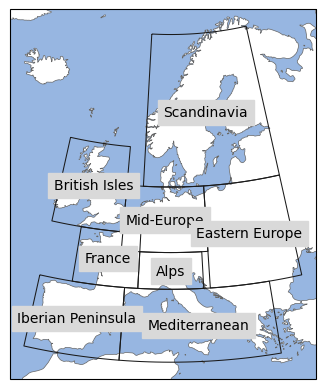

In [4]:
proj = ccrs.LambertConformal(central_longitude=10)
ax = prudence.plot(
    add_ocean=True,
    projection=proj,
    resolution="50m",
    label="name",
    line_kws=dict(lw=0.75),
)

We can use these regions with regionmask to create masks for our gridded data. Let's use some dummy topography data to show how the masking works.

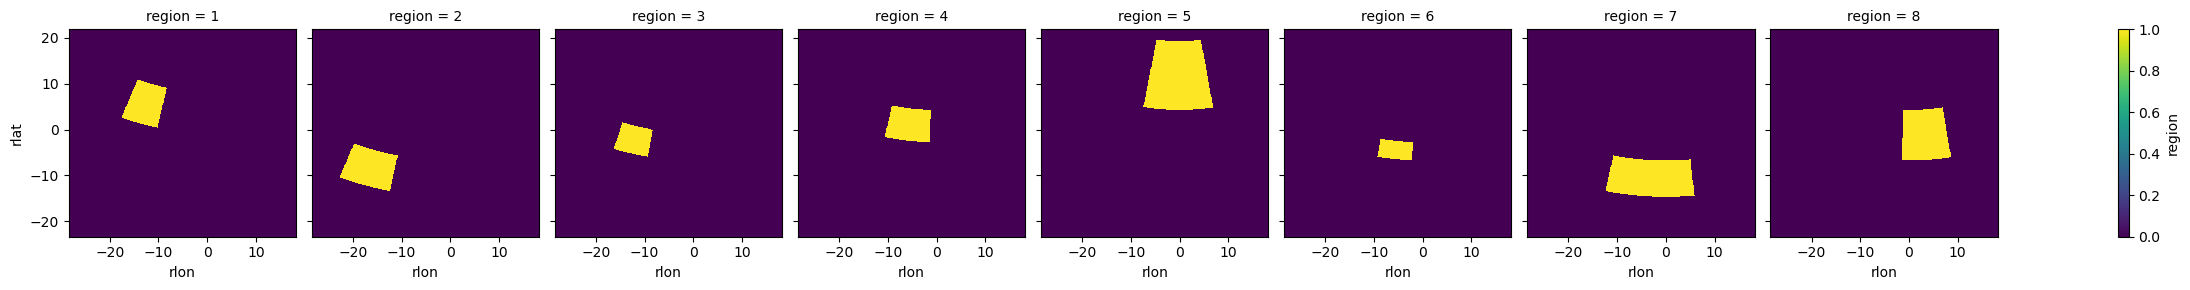

In [5]:
ds = cx.cordex_domain("EUR-11", dummy="topo")
mask_prudence = prudence.mask_3D(ds.lon, ds.lat)
mask_prudence.plot(col="region")

In [6]:
mask_prudence

<xarray.DataArray 'mask' (region: 8, rlat: 412, rlon: 424)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * rlon     (rlon) float64 -28.38 -28.27 -28.16 -28.05 ... 17.93 18.05 18.16
  * rlat     (rlat) float64 -23.38 -23.27 -23.16 -23.05 ... 21.61 21.73 21.84
    lon      (rlat, rlon) float64 -10.06 -9.964 -9.864 ... 64.55 64.76 64.96
    lat      (rlat, rlon) float64 21.99 22.03 22.07 22.11 ... 66.81 66.75 66.69
  * region   (region) int64 1 2 3 4 5 6 7 8
    abbrevs  (region) <U2 'BI' 'IP' 'FR' 'ME' 'SC' 'AL' 'MD' 'EA'
    names    (region) <U17 'British Isles' ... 'Eastern Europe'
Attributes:
    standard_name:  region

We can see that regionmask gives us a new dataset that contains a True/False mask for each region tailored to the grid of our datasets's latitude and longitude coordinates. We can then easily use these masks with `xr.where` to make an analysis for each region, e.g., we can plot only topography for a certain region:

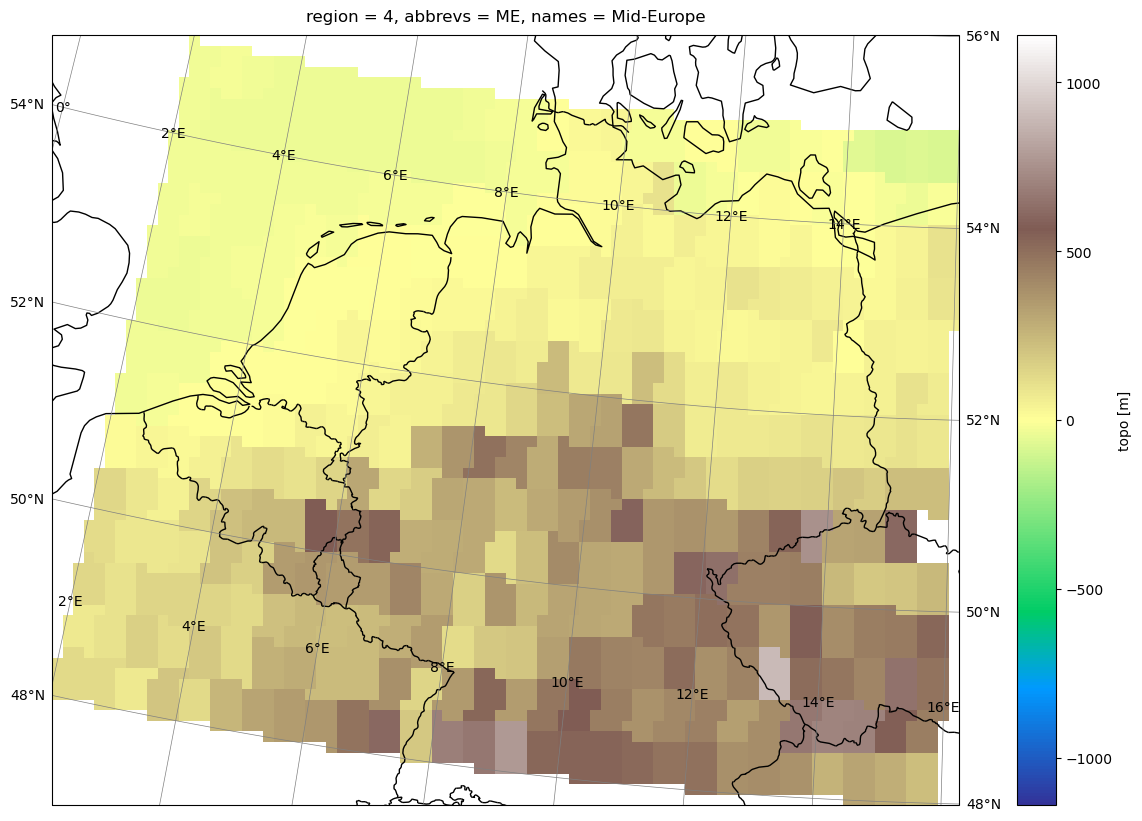

In [7]:
# get pole info for plotting
pole = (
    ds.rotated_latitude_longitude.grid_north_pole_longitude,
    ds.rotated_latitude_longitude.grid_north_pole_latitude,
)

# drop topography where mask if False
me_topo = ds.topo.where(
    mask_prudence.isel(region=(mask_prudence.names == "Mid-Europe")).squeeze(),
    drop=True,
)

# plot
plot(
    me_topo,
    transform=ccrs.RotatedPole(*pole),
    projection=ccrs.RotatedPole(*pole),
    cmap="terrain",
    # figsize=(15,10)
)

## Regional spatial average

Let's compute a spatial average over each region to compare the changes between them. We will start a dask client and open up some real datasets.

In [8]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/larsbuntemeyer/proxy/8787/status,
Dashboard: /user/larsbuntemeyer/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33761,Workers: 4
Dashboard: /user/larsbuntemeyer/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.88 GiB
Comm: tcp://127.0.0.1:40325,Total threads: 4
Dashboard: /user/larsbuntemeyer/proxy/35443/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:44501,


We open our ESM collection on AWS S3 and load all air temperature datasets into a dataset dictionary.

In [9]:
url = "https://euro-cordex.s3.eu-central-1.amazonaws.com/catalog/CORDEX-CMIP5.json"
cat = intake.open_esm_datastore(url)
subset = cat.search(
    variable_id="tas",
    experiment_id=["historical", "rcp26", "rcp45", "rcp85"],
    # driving_model_id = ["MPI-M-MPI-ESM-LR", 'IPSL-IPSL-CM5A-LR']
)

In [10]:
dsets = subset.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True},
    storage_options={"anon": True},
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.CORDEX_domain.institute_id.driving_model_id.experiment_id.member.model_id.rcm_version_id.frequency'


Sorting by experiment:

In [11]:
def sort_datasets(dsets):
    results = defaultdict(dict)
    for dset_id, ds in tqdm.tqdm(dsets.items()):
        exp_id = dset_id.split(".")[4]
        new_id = dset_id.replace(f"{exp_id}.", "")
        if exp_id != "historical":
            ds = ds.sel(time=slice("2006", "2100"))
        else:
            ds = ds.sel(time=slice("1950", "2005"))
        results[exp_id][new_id] = ds
    return OrderedDict(sorted(results.items()))


dsets_sorted = sort_datasets(dsets)

100%|██████████| 186/186 [00:00<00:00, 425.14it/s]


Here, we define our actual analysis. We compute a yearly mean for each prudence region by using regionmask's masking feature together with xarray's weighted mean.

In [14]:
def weighted_mean(ds):
    """Compute a weighted spatial mean using regionmask"""
    mask = prudence.mask_3D(ds.cf["longitude"], ds.cf["latitude"])
    # mask = mask_prudence#.assign_coords(region=mask_prudence.names)
    return ds.cf.weighted(mask).mean(dim=("X", "Y"))


def yearly_regional_mean(ds):
    """compute yearly mean for one dataset"""
    return weighted_mean(ds).groupby("time.year").mean()


def ensemble_mean(dsets):
    """compute ensemble yearly mean"""
    return xr.concat(
        [yearly_regional_mean(ds.cf["tas"]) for ds in dsets.values()],
        dim=xr.DataArray(list(dsets.keys()), dims="dset_id"),
        coords="minimal",
        compat="override",
    )

Let's check this out for one dataset before we compute it for the entire ensemble.

In [22]:
mean = yearly_regional_mean(list(dsets_sorted["historical"].values())[10].cf["tas"])
mean

<xarray.DataArray 'tas' (year: 36, region: 8)>
dask.array<transpose, shape=(36, 8), dtype=float64, chunksize=(23, 8), chunktype=numpy.ndarray>
Coordinates:
    rotated_pole  |S1 b''
    height        float64 2.0
  * region        (region) int64 1 2 3 4 5 6 7 8
    names         (region) <U17 'British Isles' ... 'Eastern Europe'
    abbrevs       (region) <U2 'BI' 'IP' 'FR' 'ME' 'SC' 'AL' 'MD' 'EA'
  * year          (year) int64 1970 1971 1972 1973 1974 ... 2002 2003 2004 2005
Attributes:
    cell_methods:   time: mean
    grid_mapping:   rotated_pole
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

We can see that, in fact, we get a timeseries of yearly mean for each PRUDENCE region. The datasets contains an additional region coordinate that we can use for plotting:

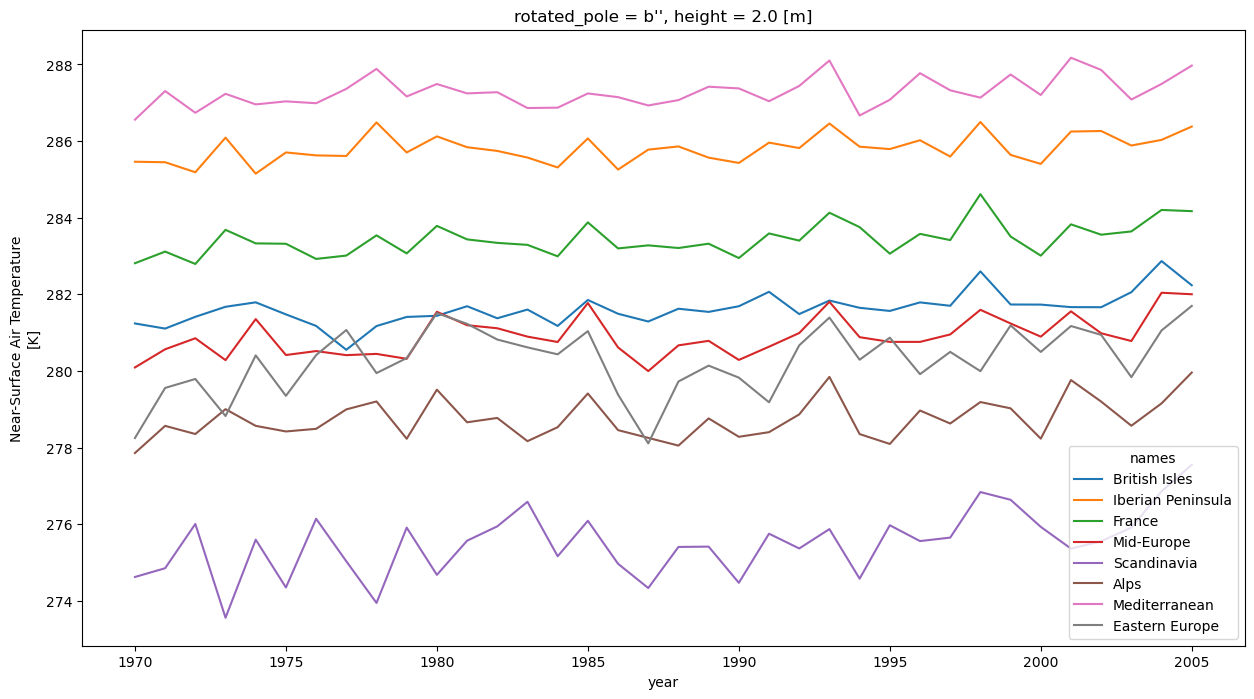

In [23]:
mean.swap_dims(region="names").plot(hue="names", figsize=(15, 8))

Now, let's trigger the heavy computation for the entire ensemble.

In [13]:
%time ensembles = {exp_id: ensemble_mean(dsets).compute() for exp_id, dsets in dsets_sorted.items()}

CPU times: user 3min, sys: 15.2 s, total: 3min 15s
Wall time: 12min 34s


In [24]:
ensembles.keys()

dict_keys(['historical', 'rcp26', 'rcp45', 'rcp85'])

In [25]:
ensemble = xr.concat(
    list(ensembles.values()),
    dim=xr.DataArray(list(ensembles.keys()), dims="experiment_id"),
    coords="minimal",
    compat="override",
)

In [26]:
dset_id = ensemble.where(ensemble < 100.0, drop=True).dset_id
ensemble.loc[dict(dset_id=dset_id)] = ensemble.sel(dset_id=dset_id) + 273.5

In [27]:
ensemble.to_netcdf("prudence-tas-ensemble.nc")

In [28]:
ensemble

<xarray.DataArray 'tas' (experiment_id: 4, dset_id: 74, year: 151, region: 8)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[282.2107418 , 286.93128853, 284.63980798, ..., 281.63338982,
          288.77574783, 282.50199637],
         [282.53776467, 287.46103499, 285.28139925, ..., 282.05806444,
          288.82877696, 282.73484321],
         [282.31529086, 287.21012818, 284.82111491, ..., 281.96693104,
          289.23218221, 282.94636519],
...
         [286.1495131 , 290.91816237, 288.58114999, ..., 284.33248825,
          291.9262367 , 285.63031609],
         [285.28652941, 291.09695127, 288.43458272, ..., 285.10354076,
          292.37664367, 285.7401946 ],
         [285.56761724, 291.20473895, 288.80000154, ..., 285.67128525,
          292.73072402, 286.76624824]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [284.3824196 , 290.56766683, 286.35423898, ..., 284.57922993,
          292.12598988, 284.89635763],
         [284.25291498, 290.10685423, 286.44420236, ..., 284.88520879,
          292.44595895, 285.00371295],
         [284.48374536, 290.85452062, 286.54731044, ..., 284.71317561,
          292.02362115, 284.41440815]]]])
Coordinates:
  * region                      (region) int64 1 2 3 4 5 6 7 8
  * year                        (year) int64 1950 1951 1952 ... 2098 2099 2100
  * dset_id                     (dset_id) <U78 'cordex-reklies.EUR-11.CLMcom-...
    rotated_latitude_longitude  int32 -2147483647
    Lambert_Conformal           |S1 b''
    crs                         |S1 b''
    rotated_pole                |S1 b''
    height                      float64 2.0
    names                       (region) <U17 'British Isles' ... 'Eastern Eu...
    abbrevs                     (region) <U2 'BI' 'IP' 'FR' ... 'AL' 'MD' 'EA'
  * experiment_id               (experiment_id) <U10 'historical' ... 'rcp85'
Attributes:
    cell_methods:   time: mean
    grid_mapping:   rotated_pole
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

Again, we will look at the change in temperature which is more interesting.

In [29]:
change = ensemble - ensemble.sel(
    experiment_id="historical", year=slice(1961, 1990)
).mean("year")

In [30]:
df = change.to_dataframe().reset_index()[
    ["year", "experiment_id", "dset_id", "names", "tas"]
]
df

,year,experiment_id,dset_id,names,tas
0,1950,historical,cordex-reklies.EUR-11.CLMcom-BTU.MPI-M-MPI-ESM...,British Isles,NaN
1,1950,historical,cordex-reklies.EUR-11.CLMcom-BTU.MPI-M-MPI-ESM...,Iberian Peninsula,NaN
2,1950,historical,cordex-reklies.EUR-11.CLMcom-BTU.MPI-M-MPI-ESM...,France,NaN
3,1950,historical,cordex-reklies.EUR-11.CLMcom-BTU.MPI-M-MPI-ESM...,Mid-Europe,NaN
4,1950,historical,cordex-reklies.EUR-11.CLMcom-BTU.MPI-M-MPI-ESM...,Scandinavia,NaN
...,...,...,...,...,...
357563,2100,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,Mid-Europe,NaN
357564,2100,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,Scandinavia,NaN
357565,2100,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,Alps,NaN
357566,2100,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,Mediterranean,NaN


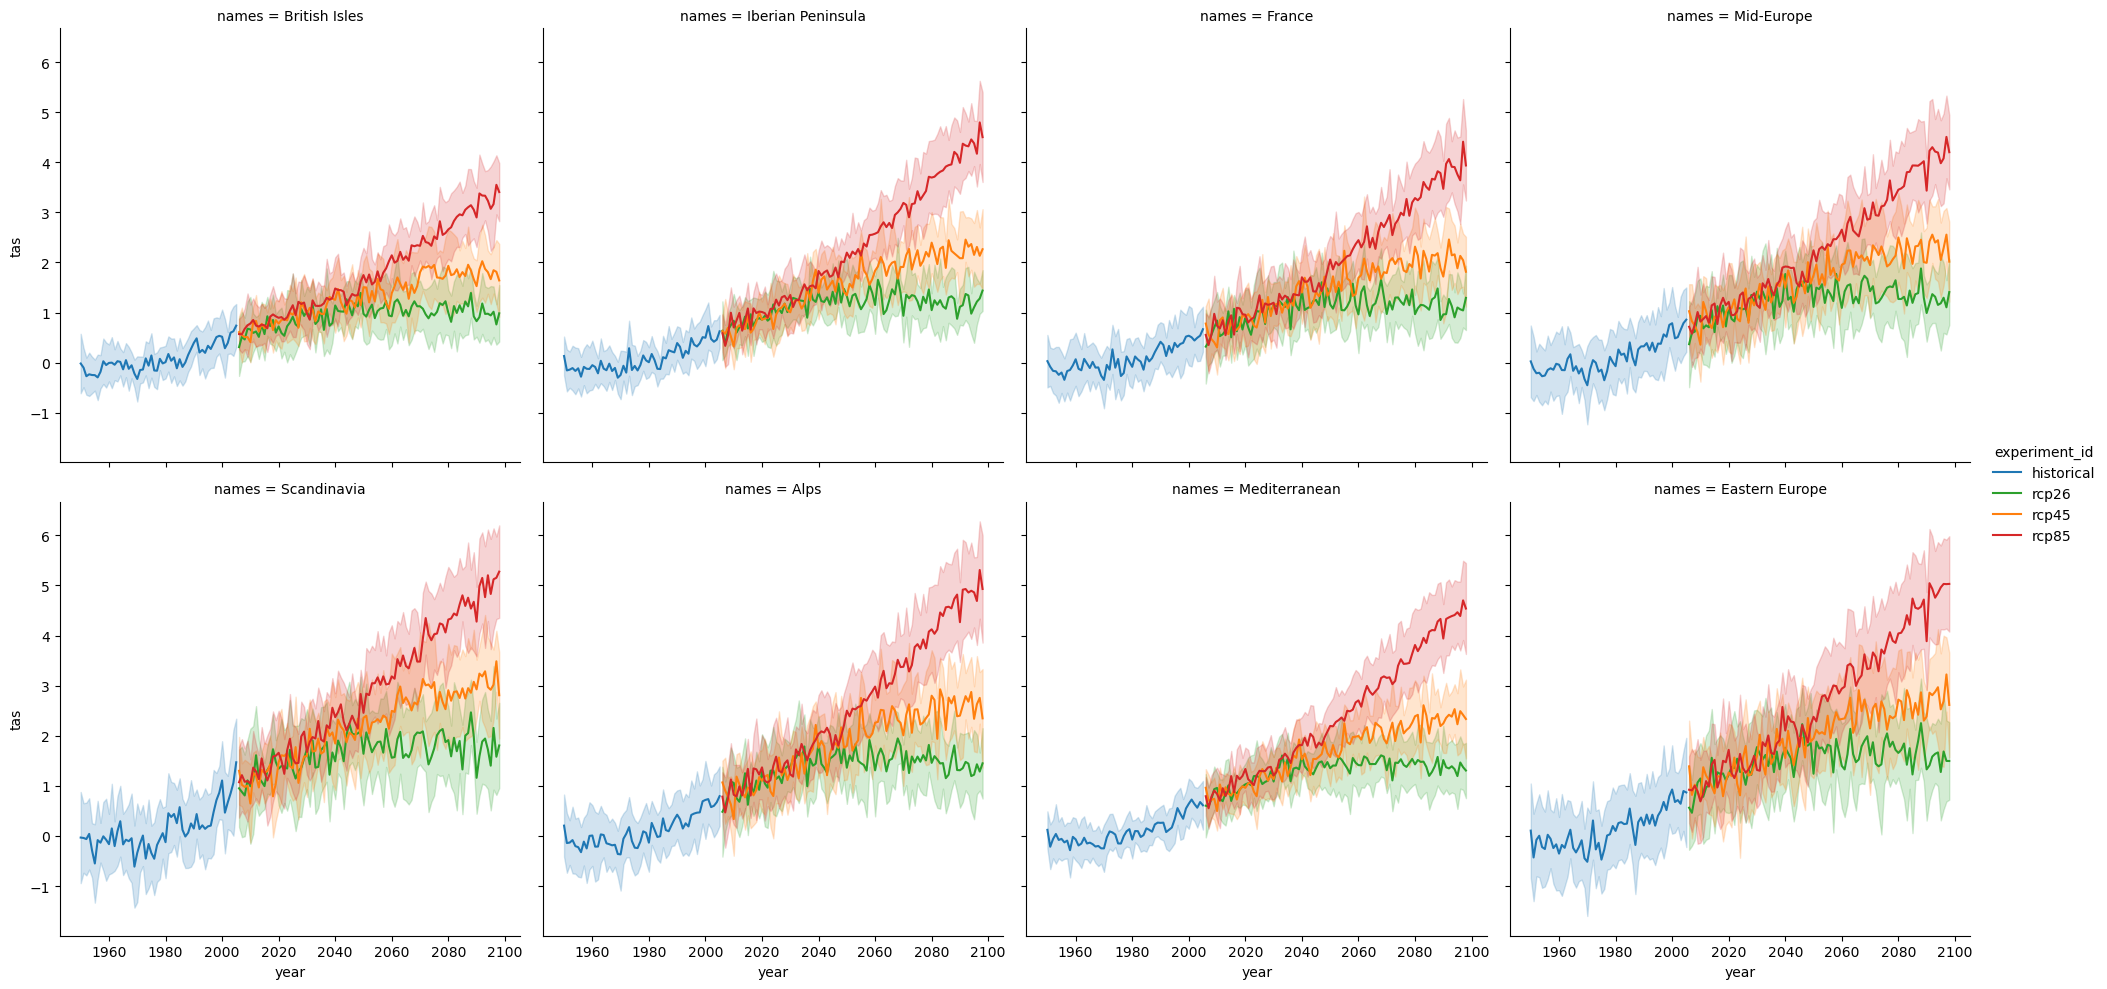

In [31]:
import seaborn as sns

palette = {"historical": "C0", "rcp26": "C2", "rcp45": "C1", "rcp85": "C3"}
g = sns.relplot(
    data=df[(df["year"] >= 1950) & (df["year"] <= 2098)],
    x="year",
    y="tas",
    hue="experiment_id",
    kind="line",
    # errorbar=("ci", 95),
    errorbar="sd",
    # aspect=2,
    palette=palette,
    col="names",
    col_wrap=4,
)
# g.set(title="Yearly model mean with 95th percentile confidence interval")